#### Lavanya Verma(2018155) Assignment 1
#### Computer Vision, Winter 2021 @ IIITD

In [1]:
%matplotlib inline

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import math
import cv2 as cv
from matplotlib import cm

In [2]:
img = Image.open('Project1.png')
data = np.asarray(img)

In [3]:
def visit(data,discovered,q,imx,imn,jmx,jmn):
    R = set(q)
    while (len(q) != 0):
        p = q.pop(); i = p[0]; j = p[1]
        R.add(p)
        for a in [-1,0,1]:
            for b in [-1,0,1]:
                if (discovered[i+a,j+b] == False and data[i+a,j+b] == True and i+a>=imn and i+a<=imx and j+b >=jmn and j+b <= jmx ):
                    discovered[i+a,j+b] = True
                    q.insert(0,(i+a,j+b))
    return list(R)

def boolConnComp(data):
    i= 0 ; j = 0 ; i_max = data.shape[0]-1 ; j_max = data.shape[1]-1
    discovered = np.full(data.shape,False,dtype=bool)
    count = 0
    Objects = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if (data[i,j] == True and discovered[i,j] == False):
                count += 1
                Ri = visit(data,discovered,[(i,j)],data.shape[0]-1,0,data.shape[1]-1,0) # shallow memory
                Objects.append(Ri)
    return Objects

def convexHull(R):
    p = (np.inf,np.inf)
    for i in range(len(R)):
        if(p[0] > R[i][0] ) or (p[0] == R[i][0] and p[1] > R[i][1]):
            p = R[i]
    R_new = R.copy()
    R_new.sort(key=lambda x : math.atan2(x[1] - p[1],x[0] - p[0]))
    st = []
    for i in range(len(R_new)):
        while( len(st)> 1 and (st[-1][0] - st[-2][0])*(R_new[i][1] - st[-2][1]) - (st[-1][1] - st[-2][1])*(R_new[i][0] - st[-2][0]) <= 0):
            st.pop()
        st.append(R_new[i])
    return st
    
def validCircle(r,c,points):
    v = True
    for i in range(len(points)):
        if (np.linalg.norm([points[i][0] - c[0],points[i][1] - c[1]]) > r):
            v = False
            break
    return v 

def circlefromPoints(p1,p2,p3):
    f = ((p1[0]**2 - p3[0]**2 + p1[1]**2 - p3[1]**2)*(p2[0] - p3[0]) - (p1[0] - p3[0])*(p2[0]**2 - p3[0]**2 + p2[1]**2 - p3[1]**2))/(2*((p2[1] - p3[1])*(p1[0]-p3[0])-(p2[0] - p3[0])*(p1[1]-p3[1])))
    try:
        g = (p1[0]**2 - p3[0]**2 + p1[1]**2 - p3[1]**2 + 2*f*(p1[1] -p3[1]))/(2*(p3[0] - p1[0]))
    except ZeroDivisionError:
        g = (p2[0]**2 - p3[0]**2 + p2[1]**2 - p3[1]**2 + 2*f*(p2[1] -p3[1]))/(2*(p3[0] - p2[0]))
    c = -(p3[0]**2 +p3[1]**2 + 2*g*p3[0] + 2*f*p3[1])
    r = np.sqrt(g**2 + f**2 - c)
    return r,(-g,-f)

def circle(points): #points : (x,y) in bottom left being origin
    minR = np.inf
    minC = (-1,-1) #null values
    for i in range(len(points)):
        for j in range(len(points)):
            if (i != j):
                r = np.linalg.norm([points[i][0] - points[j][0],points[i][1] - points[j][1]])/2
                c = ((points[i][0] + points[j][0])/2,(points[i][1] + points[j][1])/2)
                if (validCircle(r,c,points)):
                    if (r < minR):
                        minR = r
                        minC = c
                for k in range(len(points)):
                    if (i != k and j!=k):
                        r,c = circlefromPoints(points[i],points[j],points[k])
                        if (validCircle(r,c,points)):
                            if (r < minR):
                                minR = r
                                minC = c
    return minR,minC

def getMask(shape,R,c,r):
    d1 = np.full(shape,False)
    d2 = d1.copy()
    for i in range(len(R)):
        d1[R[i][0],R[i][1]] = True
    for i in range(shape[0]):
        for j in range(shape[1]):
            x = j; y = shape[0] - i
            if (np.linalg.norm([x - c[0],y-c[1]]) <=r ):
                d2[i,j] = True
    return d1,d2 

def JaccardSimilarity(d1,d2):
    i_count = 0 ; u_count = 0 # intersection count , union count
    for i in range(d1.shape[0]):
        for j in range(d1.shape[1]):
            i_count += 1 if (d1[i,j] and d2[i,j]) else 0
            u_count += 1 if (d1[i,j] or d2[i,j]) else 0
    return i_count/u_count

In [4]:
o = boolConnComp(data)

Ob: 0 22
Ob: 1 32
Ob: 2 28
Ob: 3 29
Ob: 4 26
Ob: 5 37
Ob: 6 28
Ob: 7 22
Ob: 8 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


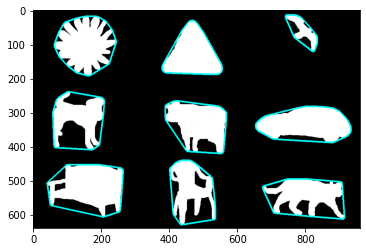

In [9]:
d1 = np.full((data.shape[0],data.shape[1],3),[0,0,0],dtype=np.float32)
hulls = []
for ob in range(len(o)):
    for i in range(len(o[ob])):
        d1[o[ob][i][0],o[ob][i][1]]  = [255,255,255]       
    R= o[ob]
    R = list(map(lambda x: (x[1],data.shape[0]-x[0]),R))
    h = convexHull(R) # x,y in bottom left being origin
    hulls.append(h)
    hi = list(map(lambda x: (-x[1] + data.shape[0],x[0]),h))
    for i in range(1,len(hi)):
        cv.line(d1,(hi[i-1][1],hi[i-1][0]),(hi[i][1],hi[i][0]),[0,255,255],3)
    cv.line(d1,(hi[-1][1],hi[-1][0]),(hi[0][1],hi[0][0]),[0,255,255],3)
    print("Ob: "+str(ob) + " " + str(len(h)))
plt.imshow(d1);plt.show()

Object 0: Center[row,column]: (67, 783) Radius: 66
Object 1: Center[row,column]: (101, 152) Radius: 91
Object 2: Center[row,column]: (129, 467) Radius: 99
Object 3: Center[row,column]: (331, 135) Radius: 100
Object 4: Center[row,column]: (348, 473) Radius: 108
Object 5: Center[row,column]: (345, 793) Radius: 140
Object 6: Center[row,column]: (534, 470) Radius: 100
Object 7: Center[row,column]: (521, 158) Radius: 118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Object 8: Center[row,column]: (563, 794) Radius: 127


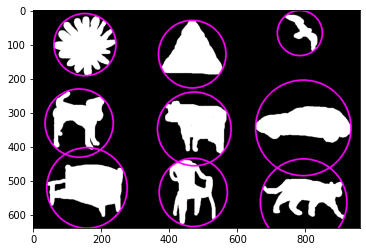

In [6]:
circles = []
for i in range(len(o)):
    r , c = circle(hulls[i])
    circles.append([r,c])
    x_cv = int(c[0]);y_cv = int(d1.shape[0] -c[1])
    cv.circle(d1,(x_cv,y_cv),int(r),(255,0,255),3)
    print("Object "+str(i)+": Center[row,column]: "+str((y_cv,x_cv)) +" Radius: "+str(int(r)))
plt.imshow(d1)
plt.show()

In [7]:
Sim = []
d1_s = []
d2_s = []
for objectNo in range(len(o)):
    d11,d21 = getMask(data.shape,o[objectNo],circles[objectNo][1],circles[objectNo][0])
    d1_s.append(d11)
    d2_s.append(d21)
    Sim.append("Jaccard Similarity for Obj {}: {} ".format(objectNo,JaccardSimilarity(d11,d21)))

Jaccard Similarity for Obj 0: 0.24354243542435425 
Jaccard Similarity for Obj 1: 0.7288794894066997 
Jaccard Similarity for Obj 2: 0.5409978727518855 
Jaccard Similarity for Obj 3: 0.40928749565931116 
Jaccard Similarity for Obj 4: 0.46680492337525925 
Jaccard Similarity for Obj 5: 0.33090808918848846 
Jaccard Similarity for Obj 6: 0.40657379871654403 
Jaccard Similarity for Obj 7: 0.4851806183495456 
Jaccard Similarity for Obj 8: 0.348225536692098 


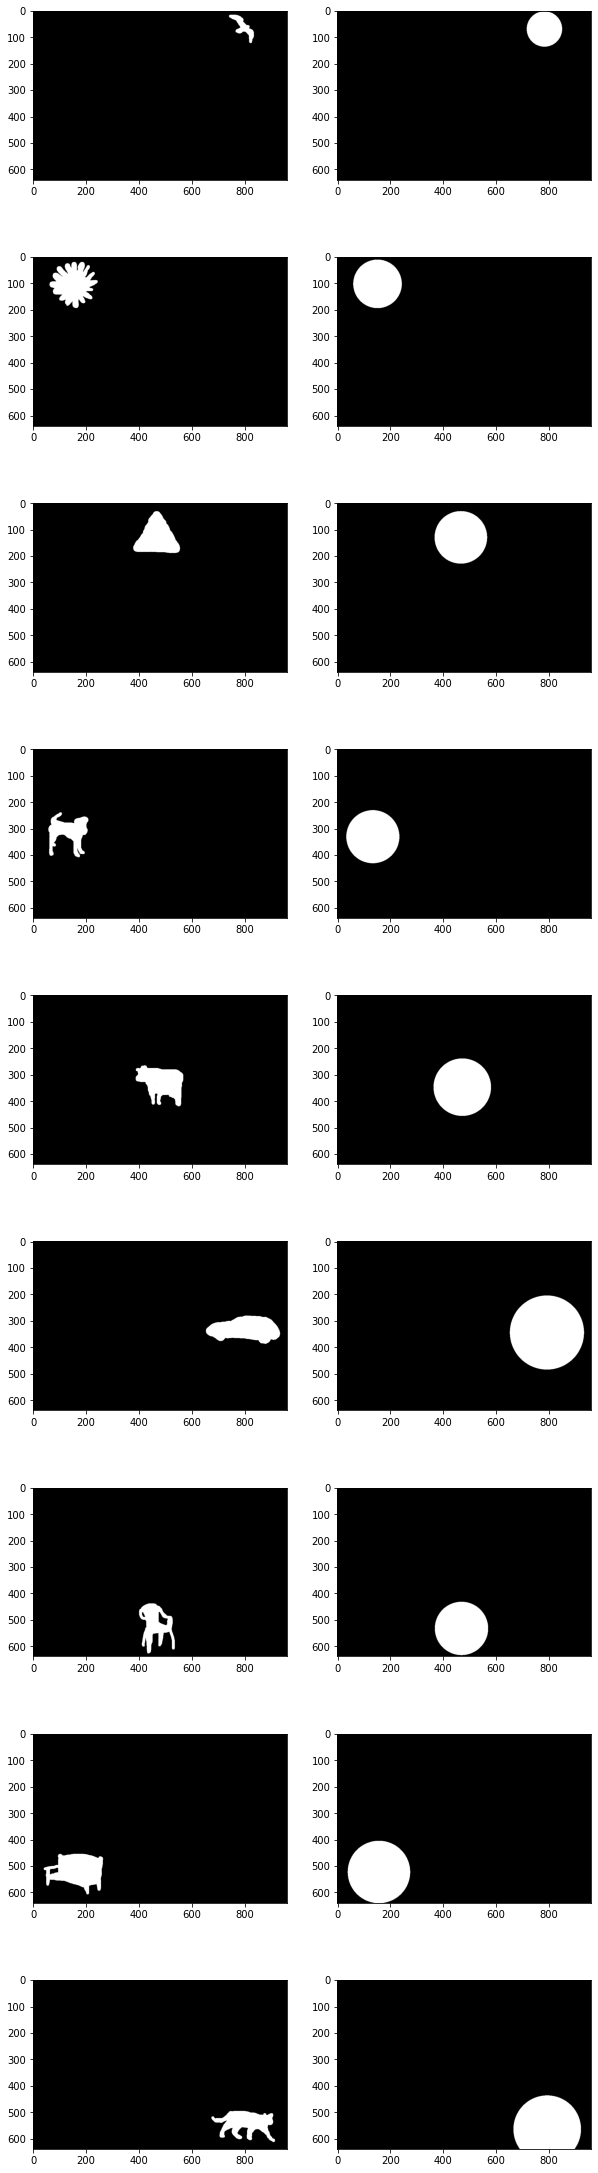

In [8]:
plt.rcParams['figure.figsize'] = [10,40]

for obNo in range(len(o)):
    print(Sim[obNo])
    plt.subplot(len(o),2,2*obNo+1)
    plt.imshow(d1_s[obNo],cmap=cm.gray)
    plt.subplot(len(o),2,2*obNo+2)
    plt.imshow(d2_s[obNo],cmap=cm.gray)
plt.show()